In [1]:
!nvidia-smi

Wed May 18 19:29:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.60.02    Driver Version: 510.60.02    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A40          On   | 00000000:41:00.0 Off |                    0 |
|  0%   39C    P8    32W / 300W |      0MiB / 46068MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import pandas as pd
import numpy as np
import random
from tqdm.auto import tqdm
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix
from torch.cuda.amp import autocast as autocast
from torch.cuda.amp import GradScaler as GradScaler
import os

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# BERT_MODEL_NAME = 'bert-base-uncased'
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# EPOCHS = 1
# MAX_TOKEN_COUNT = 512
# BATCH_SIZE = 32

In [3]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
# 设置随机数种子
setup_seed(20)

In [4]:
%%time 
train_df=pd.read_feather("Hierarchical major.feather")


# LABEL_COLUMNS=train_df.columns[11:]
# LABEL_COLUMNS

CPU times: user 35.5 s, sys: 3min 23s, total: 3min 58s
Wall time: 52.5 s


In [5]:
val_df=pd.read_feather("./autodl-nas/CoPatE/USPTO-2M_Validation.feather")

In [6]:
LABEL_COLUMNS_3 = train_df.columns[11:-139]
LABEL_COLUMNS_2 =train_df.columns[-129:]
LABEL_COLUMNS_1 = train_df.columns[-138:-129]

In [7]:
class PatentDataset(Dataset):
    """
    Pass pandas dataframe, and tokeizer along with the max token length[128 default]
    
    Example: 
    -------
    train_dataset = ToxicCommentsDataset(
      train_df,
      tokenizer,
      max_token_len=MAX_TOKEN_COUNT
    )

    sample_item = train_dataset[0]
    
    """
    
    
    def __init__(
        self,
        data: pd.DataFrame,
        tokenizer: BertTokenizer,
        max_token_len: int = 512,
        test= False
    ):
        self.data = data
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len
        self.valid = test
        
    
    def __len__(self):
        return len(self.data)
    
    
    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]

        if not self.valid:
#             comment_text = data_row['major claim']
            
            comment_text = data_row['major claim']
            
            label_3 = data_row[LABEL_COLUMNS_3]
            label_2 = data_row[LABEL_COLUMNS_2]
            label_1 = data_row[LABEL_COLUMNS_1]
            
        else:
            index_claims = range(len(data_row.claims))
            index_claims = random.sample(index_claims,k=len(data_row.claims))
            claims = [data_row.claims[i] for i in index_claims]
            comment_text = "".join(claims)
#             comment_text = "".join(data_row['claims'])
            label_3 = data_row[LABEL_COLUMNS_3]
        
        encoding = self.tokenizer.encode_plus(
            comment_text,
            max_length=self.max_token_len,
            padding="max_length",
            truncation=True,
            add_special_tokens=True, # [CLS] & [SEP]
            return_token_type_ids=False,
            return_attention_mask=True, #attention_mask
            return_tensors='pt',
        )
        
        if not self.valid:
            return dict(
            comment_text=comment_text,
            input_ids = encoding["input_ids"].flatten(),
            attention_mask=encoding["attention_mask"].flatten(),
            label_1=torch.FloatTensor(label_1),
            label_2=torch.FloatTensor(label_2),
            label_3=torch.FloatTensor(label_3),
                
        )
        else:
            return dict(
                comment_text=comment_text,
                input_ids = encoding["input_ids"].flatten(),
                attention_mask=encoding["attention_mask"].flatten(),
                label_3=torch.FloatTensor(label_3)
            )
        

In [8]:
train_dataset = PatentDataset(
  train_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

val_dataset = PatentDataset(
  val_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT,
  test=True
)

In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,drop_last = True,pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last = True,pin_memory=True)

In [10]:
Bert_model = BertModel.from_pretrained(BERT_MODEL_NAME,return_dict = True).to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
Tags_df = pd.read_feather("Tags.feather")

In [12]:
class Tags_datasets(Dataset):
    
    def __init__(
        self,
        data: pd.DataFrame,
        tokenizer: BertTokenizer,
        max_token_len: int = 512
    ):
        self.data = data
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len
    
    def __len__(self):
        return len(self.data)
    
        
    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]
        labels = data_row.Label
        tags = data_row.Tags
        
        encoding = self.tokenizer.encode_plus(
            tags,
            max_length=self.max_token_len,
            padding="max_length",
            truncation=True,
            return_tensors='pt',
        )
        
        return dict(
            index=index,
            label = labels,
            input_ids=encoding['input_ids'].flatten(),
            attention_mask = encoding['attention_mask'].flatten()
        )

In [13]:
Tags_dataset = Tags_datasets(data = Tags_df,tokenizer = tokenizer, max_token_len = MAX_TOKEN_COUNT)
Tags_dataloader = DataLoader(Tags_dataset, batch_size = 1)

In [14]:
tags_embeddings = {}

for step,batch in tqdm(enumerate(Tags_dataloader),total = len(Tags_dataloader)):
    label = batch['label'][0]
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    
    with torch.no_grad():
        output = Bert_model(input_ids,attention_mask = attention_mask)
    tag_embeddings = output.pooler_output.detach().cpu()
    tags_embeddings[label] = tag_embeddings




  0%|          | 0/674 [00:00<?, ?it/s]

In [15]:
tags_embedding = np.concatenate([tags_embeddings[key] for key in LABEL_COLUMNS_3],axis = 0)
tags_embedding = torch.tensor(tags_embedding)

In [16]:
tags_embedding = tags_embedding.to(device)

In [17]:
# Contrastive learning loss funcation

class ConLoss(nn.Module):
    
    def __init__(self, temperature = 0.1):
        super().__init__()
        self.temperature = temperature
        
    def forward(self, embeddings, label_1,label_2,label_3):
       
        # embeddings (batch_size,bert_hidden_layer) , labels (batch_size,num_classes)
        similarities = F.cosine_similarity(embeddings.unsqueeze(1),embeddings.unsqueeze(0),dim=2)/self.temperature
#         print(similarities)
        
        # mask
        logits_mask = ~torch.eye(BATCH_SIZE,dtype=torch.bool).to(device)
        labels_mask = ~torch.eye(BATCH_SIZE,dtype=torch.bool).to(device)

        exp_logits = torch.exp(similarities) * logits_mask
        loss = torch.log(exp_logits.sum(1,keepdim=True)) - similarities
        
        # labels 
        weight_1 = torch.matmul(label_1,label_1.T)
        weight_2 = torch.matmul(label_2,label_2.T)
        weight_3 = torch.matmul(label_3,label_3.T)

        weight_1 = weight_1 / torch.diag(weight_1)
        weight_1 = weight_1 * labels_mask
        weight_1 = torch.where(weight_1!=1,torch.zeros_like(weight_1).to(device),weight_1)
        weight_1 = weight_1/torch.sum(weight_1)
        
        weight_2 = weight_2 / torch.diag(weight_2)
        weight_2 = weight_2 * labels_mask
        weight_2 = torch.where(weight_2!=1,torch.zeros_like(weight_2).to(device),weight_2)
        weight_2 = weight_2/torch.sum(weight_2)
        
        weight_3 = weight_3 / torch.diag(weight_3)
        weight_3 = weight_3 * labels_mask
        weight_3 = torch.where(weight_3!=1,torch.zeros_like(weight_3).to(device),weight_3)
        weight_3 = weight_3/torch.sum(weight_3)
        
        weight = weight_1*0.2 + weight_2*0.3 + weight_3*0.5
        
        loss = weight * loss
        loss = torch.mean(loss)
        return loss
        


In [18]:
class BertNetwork(nn.Module):

    def __init__(self, n_classes: int,labels_embeddings: torch.Tensor, n_training_steps=None, n_warmup_steps=None):
        super().__init__()
        self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True) #load the pretrained bert model
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes) # add a linear layer to the bert
        self.n_training_steps = n_training_steps
        self.n_warmup_steps = n_warmup_steps
        self.criterion = nn.BCEWithLogitsLoss()
        self.Weight_1 = nn.Linear(n_classes,1)
        self.dropout = nn.Dropout(self.bert.config.hidden_dropout_prob)
        self.batch_labels_embeddings = labels_embeddings.expand(BATCH_SIZE,n_classes,self.bert.config.hidden_size)
        self.batch_labels_embeddings = self.batch_labels_embeddings.transpose(1, 2) # batch_size * 768 * 664
        self.batch_labels_embeddings.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        outputs = outputs.last_hidden_state
        
        # label-wise attention
        att = torch.bmm(outputs,self.batch_labels_embeddings)
        att = F.softmax(att,dim=1)
        joint_labels_output = torch.bmm(outputs.transpose(1,2),att)
        joint_labels_output = F.relu(self.Weight_1(joint_labels_output).squeeze(2))

        return joint_labels_output

In [19]:
class Classifier(nn.Module):
    
    def __init__(self, n_classes: int ):
        super().__init__()
        self.classifier = nn.Linear(768,n_classes)
        self.dropout = nn.Dropout(0.10)
        self.criterion = nn.BCEWithLogitsLoss()
        
    def forward(self,embeddings,labels = None):
        
        output = self.classifier(self.dropout(embeddings))
        
        if labels is not None:
            loss = self.criterion(output,labels)
            output = (loss,output)
        
        return output

In [20]:
model = BertNetwork(len(LABEL_COLUMNS_3),tags_embedding).to(device)
Conloss =  ConLoss().to(device)
classifier = Classifier(len(LABEL_COLUMNS_3)).to(device)
N_EPOCHS = EPOCHS

steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS
warmup_steps = total_training_steps // 10
warmup_steps, total_training_steps

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


(6248, 62484)

In [21]:
# optimizer = AdamW(model.parameters(), lr=2e-4)

optimizer = AdamW([
                {'params': model.parameters()},
                {'params': classifier.parameters()}],
                lr=1e-4
)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_training_steps
)

/root/miniconda3/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [22]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score

# function for evaluating the model
def evaluate(mydataloader):

    print("\nEvaluating...")
    #t0 = time.time()
    # deactivate dropout layers
    model.eval()
    classifier.eval()
    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []
    total_labels = []

    # iterate over batches
    for step,batch in tqdm(enumerate(mydataloader),total=len(mydataloader),desc='Eval'):

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
#         label_1 = batch['label_1'].to(device)
#         label_2 = batch['label_2'].to(device)
        label_3 = batch['label_3'].to(device)
        # deactivate autograd
        with autocast():
            with torch.no_grad():
                outputs = model(input_ids, attention_mask)
#                 loss1 = Conloss(outputs,label_1=label_1,label_2=label_2,label_3=label_3)
                loss2,outputs = classifier(outputs,label_3)
                if step%1000 ==0:
                    print(f"loss contrastive :loss1  loss classifier: {loss2}")
                outputs = torch.sigmoid(outputs)

#                 loss = loss1 +loss2
                loss = loss2
                total_loss = total_loss + loss.float().item()

                outputs = outputs.detach().float().cpu().numpy()
                labels = label_3.detach().float().cpu().numpy()
                total_preds.append(outputs)
                total_labels.append(labels)


    # compute the validation loss of the epoch
    avg_loss = total_loss / len(mydataloader)

    total_preds  = np.concatenate(total_preds, axis=0)
    total_labels = np.concatenate(total_labels, axis=0)
    model.train()
    print(f"Evaluate loss {total_loss / len(mydataloader)}")
    return avg_loss, total_preds, total_labels

In [24]:
# function to train the model
def train():
    
    now=time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())
    best_valid_loss = float('inf')
    model.train()
    classifier.train()
    total_loss, total_accuracy = 0, 0
    avg_loss = 0
    scaler = GradScaler()

    # empty list to save model predictions
    total_preds=[]
    # iterate over batches
    for step,batch in tqdm(enumerate(train_dataloader),total=len(train_dataloader),desc="Train"):
        
        if step%10000 == 0 and step!=0:
            valid_loss,_,_ = evaluate(val_dataloader)
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                torch.save(model.state_dict(), f"./model/CoPatE_lr_5e-5_{now}.pt")
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        label_1 = batch['label_1'].to(device)
        label_2 = batch['label_2'].to(device)
        label_3 = batch['label_3'].to(device)  
        if step > 0.8*len(train_dataloader):
            with autocast():
                outputs = model(input_ids, attention_mask)
                loss1 = Conloss(outputs,label_1=label_1,label_2=label_2,label_3=label_3)
                loss2,_ = classifier(outputs,label_3)
                loss = loss1 + loss2

            optimizer.zero_grad()
            if step%100 == 0:
                print(f"STEP {step}: loss contrastive :{loss1}  loss classifier: {loss2}")
        else:
            with autocast():
                outputs = model(input_ids, attention_mask)
                loss,_ = classifier(outputs,label_3)
            optimizer.zero_grad()
            if step%100 == 0:
                print(f"STEP {step}: loss classifier: {loss}")
        # add on to the total loss
        losses.append(loss.item())
        total_loss = total_loss + loss.item()
        scaler.scale(loss).backward()

        scaler.unscale_(optimizer)
        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        scaler.step(optimizer)
        scheduler.step()
        scaler.update()
        # model predictions are stored on GPU. So, push it to CPU
        outputs=outputs.detach().float().cpu().numpy()

        # append the model predictions
        total_preds.append(outputs)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)
    print(f"{step}: {avg_loss}")
  

    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

In [ ]:
train_loss, _ = train()

Train:   0%|          | 0/62484 [00:00<?, ?it/s]

STEP 0: loss classifier: 0.006539450027048588
STEP 100: loss classifier: 0.005286253523081541
STEP 200: loss classifier: 0.00577233312651515
STEP 300: loss classifier: 0.006785879377275705
STEP 400: loss classifier: 0.006582504138350487
STEP 500: loss classifier: 0.0052382079884409904
STEP 600: loss classifier: 0.005633514374494553
STEP 700: loss classifier: 0.00442507304251194
STEP 800: loss classifier: 0.006413094699382782
STEP 900: loss classifier: 0.005706325173377991
STEP 1000: loss classifier: 0.005523086991161108
STEP 1100: loss classifier: 0.00558877270668745
STEP 1200: loss classifier: 0.005359854083508253
STEP 1300: loss classifier: 0.0065163918770849705
STEP 1400: loss classifier: 0.003570703323930502
STEP 1500: loss classifier: 0.007230360526591539
STEP 1600: loss classifier: 0.00527672516182065
STEP 1700: loss classifier: 0.00831750500947237
STEP 1800: loss classifier: 0.00614092405885458
STEP 1900: loss classifier: 0.004562295041978359
STEP 2000: loss classifier: 0.005175

Eval:   0%|          | 0/1634 [00:00<?, ?it/s]

loss contrastive :loss1  loss classifier: 0.005678244866430759
loss contrastive :loss1  loss classifier: 0.004505077842622995
Evaluate loss 0.005179616474293428
STEP 10000: loss classifier: 0.003268686356022954
STEP 10100: loss classifier: 0.0038966115098446608
STEP 10200: loss classifier: 0.004677766002714634
STEP 10300: loss classifier: 0.003893543966114521
STEP 10400: loss classifier: 0.005082374904304743
STEP 10500: loss classifier: 0.006504149176180363
STEP 10600: loss classifier: 0.004028094932436943
STEP 10700: loss classifier: 0.005414608400315046
STEP 10800: loss classifier: 0.005910307168960571
STEP 10900: loss classifier: 0.0037751924246549606
STEP 11000: loss classifier: 0.005412472411990166
STEP 11100: loss classifier: 0.004746235907077789
STEP 11200: loss classifier: 0.004026717506349087
STEP 11300: loss classifier: 0.00552744185552001
STEP 11400: loss classifier: 0.005490193609148264
STEP 11500: loss classifier: 0.005467909388244152
STEP 11600: loss classifier: 0.0041698

Eval:   0%|          | 0/1634 [00:00<?, ?it/s]

loss contrastive :loss1  loss classifier: 0.005192983895540237
loss contrastive :loss1  loss classifier: 0.0043900529853999615
Evaluate loss 0.004882681305916932
STEP 20000: loss classifier: 0.0031283122953027487
STEP 20100: loss classifier: 0.0062094018794596195
STEP 20200: loss classifier: 0.005252518225461245
STEP 20300: loss classifier: 0.004182801581919193
STEP 20400: loss classifier: 0.006056245416402817
STEP 20500: loss classifier: 0.004632787313312292
STEP 20600: loss classifier: 0.004803474526852369
STEP 20700: loss classifier: 0.004556267522275448
STEP 20800: loss classifier: 0.004039531573653221
STEP 20900: loss classifier: 0.0046360306441783905
STEP 21000: loss classifier: 0.0033480986021459103
STEP 21100: loss classifier: 0.0044764308258891106
STEP 21200: loss classifier: 0.0042644077911973
STEP 21300: loss classifier: 0.004757292568683624
STEP 21400: loss classifier: 0.004079400096088648
STEP 21500: loss classifier: 0.004243966657668352
STEP 21600: loss classifier: 0.0051

Eval:   0%|          | 0/1634 [00:00<?, ?it/s]

loss contrastive :loss1  loss classifier: 0.0051286290399730206
loss contrastive :loss1  loss classifier: 0.003897738875821233
Evaluate loss 0.004662337076862775
STEP 30000: loss classifier: 0.005140595603734255
STEP 30100: loss classifier: 0.0047587184235453606
STEP 30200: loss classifier: 0.005003014579415321
STEP 30300: loss classifier: 0.003529478795826435
STEP 30400: loss classifier: 0.003717755666002631
STEP 30500: loss classifier: 0.005274747498333454
STEP 30600: loss classifier: 0.0057831620797514915
STEP 30700: loss classifier: 0.004950101487338543
STEP 30800: loss classifier: 0.0038335053250193596
STEP 30900: loss classifier: 0.0038451431319117546
STEP 31000: loss classifier: 0.005153605714440346
STEP 31100: loss classifier: 0.006822861731052399
STEP 31200: loss classifier: 0.004872429650276899
STEP 31300: loss classifier: 0.004087185952812433
STEP 31400: loss classifier: 0.005991858895868063
STEP 31500: loss classifier: 0.004975345451384783
STEP 31600: loss classifier: 0.005

In [25]:
losses = []
train_loss, _ = train()


Train:   0%|          | 0/62484 [00:00<?, ?it/s]

STEP 0: loss classifier: 0.698204517364502
STEP 100: loss classifier: 0.6855059266090393
STEP 200: loss classifier: 0.594409167766571
STEP 300: loss classifier: 0.46241897344589233
STEP 400: loss classifier: 0.3067774474620819
STEP 500: loss classifier: 0.1650008261203766
STEP 600: loss classifier: 0.07319805026054382
STEP 700: loss classifier: 0.03505728393793106
STEP 800: loss classifier: 0.025783732533454895
STEP 900: loss classifier: 0.02103722095489502
STEP 1000: loss classifier: 0.02005934901535511
STEP 1100: loss classifier: 0.01715826615691185
STEP 1200: loss classifier: 0.015239284373819828
STEP 1300: loss classifier: 0.013688690029084682
STEP 1400: loss classifier: 0.014107989147305489
STEP 1500: loss classifier: 0.01434738002717495
STEP 1600: loss classifier: 0.013854528777301311
STEP 1700: loss classifier: 0.011854343116283417
STEP 1800: loss classifier: 0.012707356363534927
STEP 1900: loss classifier: 0.014921237714588642
STEP 2000: loss classifier: 0.012868174351751804
ST

KeyboardInterrupt: 

In [2]:
import matplotlib.pyplot as plt


In [27]:
losses_with_tags = losses

In [3]:
losses_without_tags = pd.read_csv("losses_without_tags 1e-4.csv",header=0,index_col=0)

In [4]:
losses_without_tags = losses_without_tags.T.to_dict()[0].values()

In [5]:
losses_without_tags = list(losses_without_tags)

In [25]:
k=26

In [7]:
with open("losses_Tags_1e-4.txt",'r') as fr:
    data=fr.readlines()

In [20]:
losses_with_tags = [float(data[i].split()[-1]) for i in range(50)]

In [6]:
l2 = [x for i,x in enumerate(losses_without_tags) if i%100==0][:50]

In [16]:
l1 =[x for i,x in enumerate(losses_with_tags) if i%100==0][:50]

In [21]:
l1 = losses_with_tags

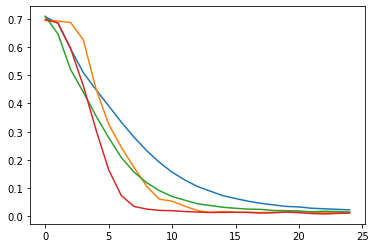

In [55]:
import matplotlib.pyplot as plt
plt.plot(range(k),l3[:k])
plt.plot(range(k),l4[:k])
plt.plot(range(k),l2[:k])
plt.plot(range(k),l1[:k])
plt.show()

In [30]:
losses_without_tags_1 = pd.read_csv("losses lr 5e-5.csv",index_col=0)

In [41]:
l3 = list(losses_without_tags_1.to_dict()['0'].values())

In [42]:
losses_with_tags_1 = pd.read_csv("losses_Tags 5e-5.csv",index_col=0)

In [44]:
l4 = list(losses_with_tags_1.to_dict()['0'].values())

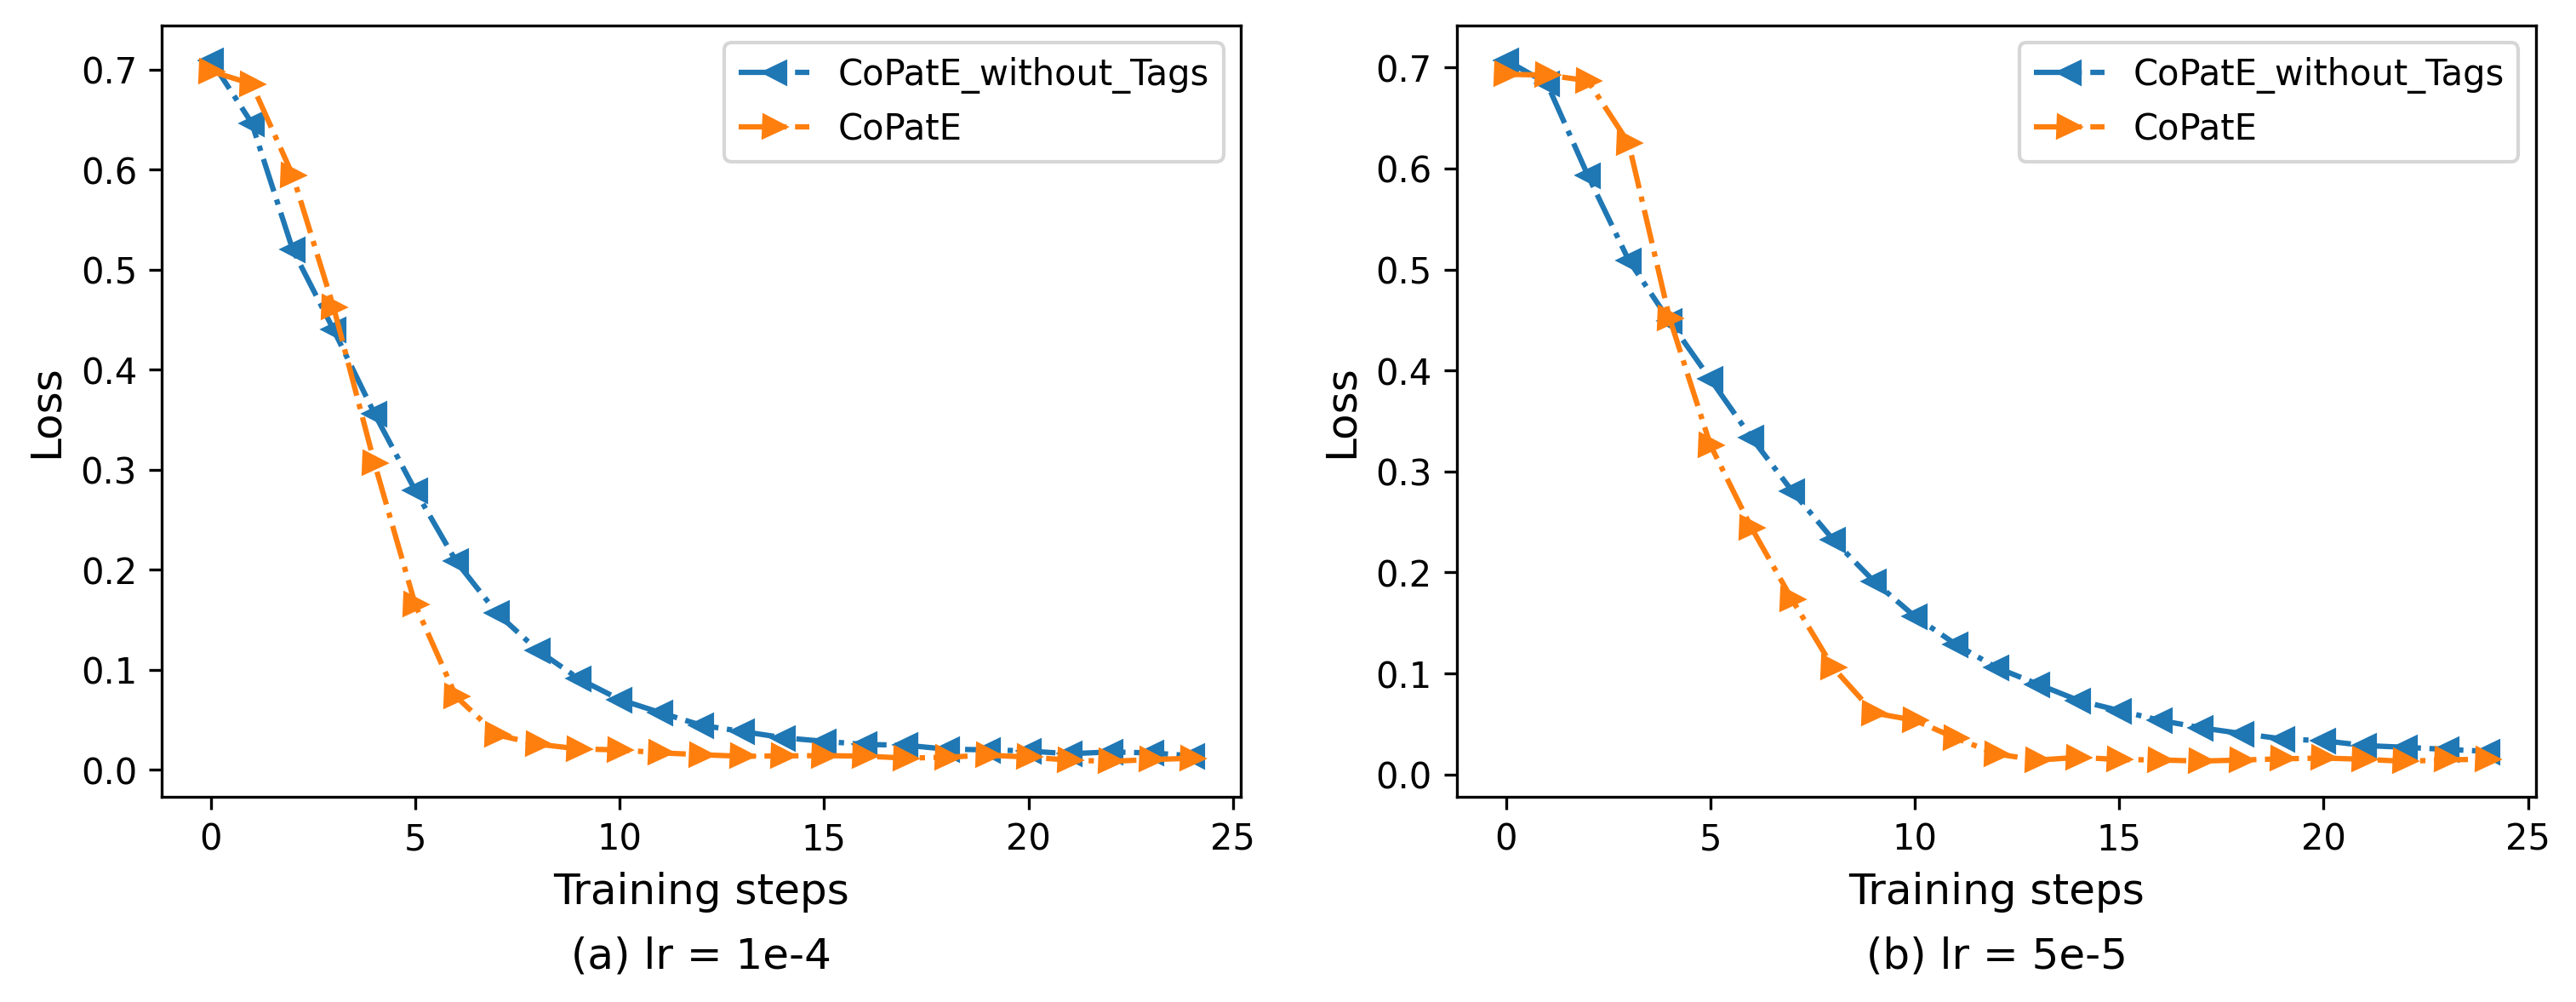

In [91]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,4),dpi=300)
plt.subplot(121)
plt.plot(range(k),l2[:k],linestyle='-.',label='CoPatE_without_Tags',marker='<')
plt.plot(range(k),l1[:k],linestyle='-.',label='CoPatE',marker='>')
plt.title("(a) lr = 1e-4",x=0.5,y=-0.25, fontdict={"family": "Times New Roman", "size": 12})
plt.xlabel('Training steps', fontdict={"family": "Times New Roman", "size": 12})
plt.ylabel('Loss', fontdict={"family": "Times New Roman", "size": 12})

plt.legend()
plt.subplot(122)
plt.plot(range(k),l3[:k],linestyle='-.',label='CoPatE_without_Tags',marker='<')
plt.plot(range(k),l4[:k],linestyle='-.',label='CoPatE',marker='>')
plt.title("(b) lr = 5e-5",x=0.5,y=-0.25, fontdict={"family": "Times New Roman", "size": 12})
plt.xlabel('Training steps', fontdict={"family": "Times New Roman", "size": 12})
plt.ylabel('Loss', fontdict={"family": "Times New Roman", "size": 12})
plt.legend()
fig.savefig("losses decending.pdf",bbox_inches='tight')
plt.show()

In [ ]:
torch.save(classifier.state_dict(), f"./model/CoPatE_classifier_lr_5e-5_{now}.pt")

## Training

In [26]:
model.load_state_dict(torch.load("./model/CoPatE_final.pt"))
classifier.load_state_dict(torch.load("./model/CoPatE_classifier_final.pt"))
    

<All keys matched successfully>

In [33]:
import numpy as np
import pandas as pd
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score)


true = np.array(total_labels)
pred = np.array(total_preds>0.5)

dic = {
    "Accuracy" : accuracy_score(true,pred),
    "Precision-micro" : precision_score(true,pred,average='micro'),
    "Precision-macro" : precision_score(true,pred,average='macro'),
    "recall-micro" : recall_score(true,pred,average='micro'),
    "recall-macro" : recall_score(true,pred,average='macro'),
    "f1_micro" : f1_score(true,pred,average='micro'),
    "f1-macro" : f1_score(true,pred,average='macro')
}

/root/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [46]:
# CoPatE lr 5e-5
# k = 5 
dic

{'Accuracy': 0.4128605769230769,
 'Precision-micro': 0.8163063211751114,
 'Precision-macro': 0.4383201502545192,
 'recall-micro': 0.5383108402263822,
 'recall-macro': 0.2781757794217007,
 'f1_micro': 0.6487833672197809,
 'f1-macro': 0.32267381847952}

In [35]:
# CoPatE lr 5e-5
# k = 3 
dic

{'Accuracy': 0.41185897435897434,
 'Precision-micro': 0.8182578164186591,
 'Precision-macro': 0.43324047869837756,
 'recall-micro': 0.5326512842838484,
 'recall-macro': 0.276700314323264,
 'f1_micro': 0.6452633660755488,
 'f1-macro': 0.32074197267429944}

In [42]:
# CoPatE lr 5e-5
# k =1 
dic

{'Accuracy': 0.3870192307692308,
 'Precision-micro': 0.8152213026268442,
 'Precision-macro': 0.42394439589242405,
 'recall-micro': 0.4931432303003918,
 'recall-macro': 0.25397483904525403,
 'f1_micro': 0.6145395361453954,
 'f1-macro': 0.3008877394184272}

In [30]:
# CoPatE lr 5e-5
# first 512
dic

{'Accuracy': 0.40224358974358976,
 'Precision-micro': 0.8105420188960716,
 'Precision-macro': 0.42904585301665904,
 'recall-micro': 0.5322159338267305,
 'recall-macro': 0.27312973463919726,
 'f1_micro': 0.6425333420931607,
 'f1-macro': 0.3175687870825584}

In [34]:
# CoPatE lr 5e-5
# random
dic

{'Accuracy': 0.40184294871794873,
 'Precision-micro': 0.8077496274217586,
 'Precision-macro': 0.42080530628782864,
 'recall-micro': 0.5309098824553766,
 'recall-macro': 0.267595798359459,
 'f1_micro': 0.6407040126091811,
 'f1-macro': 0.3121689450876504}

In [27]:
test_df = pd.read_feather("Test.feather")

In [32]:
test_dataset = PatentDataset(
  test_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT,
  test = True
)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False,drop_last=True)

avg_loss, total_preds, total_labels = evaluate(test_dataloader)


Evaluating...


Eval:   0%|          | 0/156 [00:00<?, ?it/s]

loss contrastive :loss1  loss classifier: 0.005369642749428749
Evaluate loss 0.005041858215684978


In [43]:
class PatentDataset(Dataset):
    """
    Pass pandas dataframe, and tokeizer along with the max token length[128 default]
    
    Example: 
    -------
    train_dataset = ToxicCommentsDataset(
      train_df,
      tokenizer,
      max_token_len=MAX_TOKEN_COUNT
    )

    sample_item = train_dataset[0]
    
    """
    
    
    def __init__(
        self,
        data: pd.DataFrame,
        tokenizer: BertTokenizer,
        max_token_len: int = 512,
        test= False
    ):
        self.data = data
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len
        self.valid = test
        
    
    def __len__(self):
        return len(self.data)
    
    
    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]

        if not self.valid:
            comment_text = data_row['major claim 5']
            label_3 = data_row[LABEL_COLUMNS_3]
            label_2 = data_row[LABEL_COLUMNS_2]
            label_1 = data_row[LABEL_COLUMNS_1]
            
        else:
            comment_text = data_row['major claim 5']
            label_3 = data_row[LABEL_COLUMNS_3]
        
        encoding = self.tokenizer.encode_plus(
            comment_text,
            max_length=self.max_token_len,
            padding="max_length",
            truncation=True,
            add_special_tokens=True, # [CLS] & [SEP]
            return_token_type_ids=False,
            return_attention_mask=True, #attention_mask
            return_tensors='pt',
        )
        
        if not self.valid:
            return dict(
            comment_text=comment_text,
            input_ids = encoding["input_ids"].flatten(),
            attention_mask=encoding["attention_mask"].flatten(),
            label_1=torch.FloatTensor(label_1),
            label_2=torch.FloatTensor(label_2),
            label_3=torch.FloatTensor(label_3),
                
        )
        else:
            return dict(
                comment_text=comment_text,
                input_ids = encoding["input_ids"].flatten(),
                attention_mask=encoding["attention_mask"].flatten(),
                label_3=torch.FloatTensor(label_3)
            )
        

In [46]:
class PatentDataset(Dataset):
    """
    Pass pandas dataframe, and tokeizer along with the max token length[128 default]
    
    Example: 
    -------
    train_dataset = ToxicCommentsDataset(
      train_df,
      tokenizer,
      max_token_len=MAX_TOKEN_COUNT
    )

    sample_item = train_dataset[0]
    
    """
    
    
    def __init__(
        self,
        data: pd.DataFrame,
        tokenizer: BertTokenizer,
        max_token_len: int = 512
    ):
        self.data = data
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len
        
    
    def __len__(self):
        return len(self.data)
    
    
    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]
        
        
        comment_text = data_row['major claim 5']
#         comment_text = "".join(data_row['claim'])
        
#         index_claims = range(len(data_row.claims))
#         index_claims = random.sample(index_claims,k=len(data_row.claims))
#         claims = [data_row.claims[i] for i in index_claims]
#         comment_text = "".join(claims)
        
        query = data_row.publication_title.lower()
        
        encoding = self.tokenizer.batch_encode_plus(
            [query, comment_text],
            max_length=self.max_token_len,
            padding="max_length",
            truncation=True,
            add_special_tokens=True,
            return_tensors='pt',
        )
        
        return dict(
            index = index,
            comment_text=comment_text,
            query = query,
            input_ids = encoding["input_ids"],
            attention_mask=encoding["attention_mask"]
        )


In [47]:
test_dataset = PatentDataset(
  test_df,
  tokenizer,
  max_token_len=512
)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False,drop_last=True)

In [48]:
query_patent = {}
for step,batch in tqdm(enumerate(test_dataloader),total = len(test_dataloader)):
    input_ids = batch['input_ids'].transpose(0,1).to(device)
    attention_mask = batch['attention_mask'].transpose(0,1).to(device)
    with autocast():
        with torch.no_grad():
            query_cls_embedding = model.bert(input_ids[0],attention_mask[0]).last_hidden_state[:,0]
            patent_cls_embedding = model.bert(input_ids[1],attention_mask[1]).last_hidden_state[:,0]
    index = batch['index']
    for i,patent in enumerate(index):
        q = query_cls_embedding[i].detach().float().cpu()
        v = patent_cls_embedding[i].detach().float().cpu()
        query_patent[int(patent)] = (q,v)

  0%|          | 0/156 [00:00<?, ?it/s]

In [49]:
query_list = [v[0] for v in query_patent.values()]
patent_list = [v[1] for v in query_patent.values()]

query_matrix = torch.vstack(query_list)
patent_matrix = torch.vstack(patent_list)

In [50]:
# k = 5

K0 = 100
K1 = 200
K2 = 500

precision_0 = []
recall_0 = []

precision_1 = []
recall_1 = []

precision_2 = []
recall_2 = []

# for i in tqdm(range(len(query_matrix))):
for i in tqdm(range(len(query_matrix))):    
    relv_patents = test_df['relv_patents'][i]
    similarities = F.cosine_similarity(query_matrix[i].expand_as(patent_matrix),patent_matrix)
    
    _,indices_0 = torch.topk(similarities,k=K0)
    indices_0 = indices_0.numpy()
    retrievaled = len(np.intersect1d(indices_0,relv_patents))

    precision_0.append(retrievaled/K0)
    recall_0.append(retrievaled/len(relv_patents))
    
    _,indices_1 = torch.topk(similarities,k=K1)
    indices_1 = indices_1.numpy()
    retrievaled = len(np.intersect1d(indices_1,relv_patents))
    precision_1.append(retrievaled/K1)
    recall_1.append(retrievaled/len(relv_patents))
    
    _,indices_2 = torch.topk(similarities,k=K2)
    indices_2 = indices_2.numpy()
    retrievaled = len(np.intersect1d(indices_2,relv_patents))
    precision_2.append(retrievaled/K2)
    recall_2.append(retrievaled/len(relv_patents))

print(f"Top@{K0} precision: {np.mean(precision_0):.3f}")
print(f"Top@{K0} recall: {np.mean(recall_0):.3f}")
print(f"Top@{K1} precision: {np.mean(precision_1):.3f}")
print(f"Top@{K1} recall: {np.mean(recall_1):.3f}")
print(f"Top@{K2} precision: {np.mean(precision_2):.3f}")
print(f"Top@{K2} recall: {np.mean(recall_2):.3f}")

  0%|          | 0/4992 [00:00<?, ?it/s]

Top@100 precision: 0.238
Top@100 recall: 0.488
Top@200 precision: 0.196
Top@200 recall: 0.598
Top@500 precision: 0.131
Top@500 recall: 0.753


In [40]:
# first 

K0 = 100
K1 = 200
K2 = 500

precision_0 = []
recall_0 = []

precision_1 = []
recall_1 = []

precision_2 = []
recall_2 = []

# for i in tqdm(range(len(query_matrix))):
for i in tqdm(range(len(query_matrix))):    
    relv_patents = test_df['relv_patents'][i]
    similarities = F.cosine_similarity(query_matrix[i].expand_as(patent_matrix),patent_matrix)
    
    _,indices_0 = torch.topk(similarities,k=K0)
    indices_0 = indices_0.numpy()
    retrievaled = len(np.intersect1d(indices_0,relv_patents))

    precision_0.append(retrievaled/K0)
    recall_0.append(retrievaled/len(relv_patents))
    
    _,indices_1 = torch.topk(similarities,k=K1)
    indices_1 = indices_1.numpy()
    retrievaled = len(np.intersect1d(indices_1,relv_patents))
    precision_1.append(retrievaled/K1)
    recall_1.append(retrievaled/len(relv_patents))
    
    _,indices_2 = torch.topk(similarities,k=K2)
    indices_2 = indices_2.numpy()
    retrievaled = len(np.intersect1d(indices_2,relv_patents))
    precision_2.append(retrievaled/K2)
    recall_2.append(retrievaled/len(relv_patents))

print(f"Top@{K0} precision: {np.mean(precision_0):.3f}")
print(f"Top@{K0} recall: {np.mean(recall_0):.3f}")
print(f"Top@{K1} precision: {np.mean(precision_1):.3f}")
print(f"Top@{K1} recall: {np.mean(recall_1):.3f}")
print(f"Top@{K2} precision: {np.mean(precision_2):.3f}")
print(f"Top@{K2} recall: {np.mean(recall_2):.3f}")

  0%|          | 0/4992 [00:00<?, ?it/s]

Top@100 precision: 0.237
Top@100 recall: 0.484
Top@200 precision: 0.196
Top@200 recall: 0.595
Top@500 precision: 0.131
Top@500 recall: 0.752


In [45]:
# random 

K0 = 100
K1 = 200
K2 = 500

precision_0 = []
recall_0 = []

precision_1 = []
recall_1 = []

precision_2 = []
recall_2 = []

# for i in tqdm(range(len(query_matrix))):
for i in tqdm(range(len(query_matrix))):    
    relv_patents = test_df['relv_patents'][i]
    similarities = F.cosine_similarity(query_matrix[i].expand_as(patent_matrix),patent_matrix)
    
    _,indices_0 = torch.topk(similarities,k=K0)
    indices_0 = indices_0.numpy()
    retrievaled = len(np.intersect1d(indices_0,relv_patents))

    precision_0.append(retrievaled/K0)
    recall_0.append(retrievaled/len(relv_patents))
    
    _,indices_1 = torch.topk(similarities,k=K1)
    indices_1 = indices_1.numpy()
    retrievaled = len(np.intersect1d(indices_1,relv_patents))
    precision_1.append(retrievaled/K1)
    recall_1.append(retrievaled/len(relv_patents))
    
    _,indices_2 = torch.topk(similarities,k=K2)
    indices_2 = indices_2.numpy()
    retrievaled = len(np.intersect1d(indices_2,relv_patents))
    precision_2.append(retrievaled/K2)
    recall_2.append(retrievaled/len(relv_patents))

print(f"Top@{K0} precision: {np.mean(precision_0):.3f}")
print(f"Top@{K0} recall: {np.mean(recall_0):.3f}")
print(f"Top@{K1} precision: {np.mean(precision_1):.3f}")
print(f"Top@{K1} recall: {np.mean(recall_1):.3f}")
print(f"Top@{K2} precision: {np.mean(precision_2):.3f}")
print(f"Top@{K2} recall: {np.mean(recall_2):.3f}")

  0%|          | 0/4992 [00:00<?, ?it/s]

Top@100 precision: 0.236
Top@100 recall: 0.479
Top@200 precision: 0.194
Top@200 recall: 0.591
Top@500 precision: 0.130
Top@500 recall: 0.749
